In [122]:
# Packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest

from imblearn.pipeline import Pipeline

In [110]:
# Print more rows and columns of pandas.DataFrame
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [111]:
# Change path if needed
path = r'C:\Users\user\Desktop\KUL - Mstat\Big Data Platforms and Technologies\project'
data = pd.read_csv(path + r'\ctrain.csv')

In [113]:
# Weight of evidence & Information value
def get_information_value(data, features):
    # cross tab
    tab = pd.crosstab(data[features], data['fraud'])
    # weight of evidence
    tab['all'] = tab[['Y', 'N']].sum(axis = 1) 
    tab['share'] = tab['all'] / tab['all'].sum(axis = 0)
    tab['Y_rate'] = tab['Y'] / tab['all']
    tab['N_dist'] = tab['N'] / tab['N'].sum()
    tab['Y_dist'] = tab['Y'] / tab['Y'].sum()
    tab['WoE'] = np.log(tab['N_dist'] / tab['Y_dist'])
    tab = tab.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    # information value
    tab['IV'] = tab['WoE'] * (tab['N_dist'] - tab['Y_dist'])
    return tab[np.abs(tab['IV']) > 0.01].index.values # threshold 0.01

In [114]:
# apply get_information_value
claim_postal_code_list = get_information_value(data, 'claim_postal_code')
policy_holder_postal_code_list = get_information_value(data, 'policy_holder_postal_code')
driver_postal_code_list = get_information_value(data, 'driver_postal_code')
third_party_1_postal_code_list = get_information_value(data, 'third_party_1_postal_code')
third_party_2_postal_code_list = get_information_value(data, 'third_party_2_postal_code')
repair_postal_code_list = get_information_value(data, 'repair_postal_code')
claim_vehicle_brand_list = get_information_value(data, 'claim_vehicle_brand')
policy_coverage_type_list = get_information_value(data, 'policy_coverage_type')

C:\Users\user\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [115]:
def handle_age(value):
    # A simple program to discretize age
    if pd.isna(value):
        return 'unknown'
    else:
        if value <= 20:
            return '<=20'
#        elif value <= 30:
#            return '<=30'
        elif value <= 40:
            return '<=40'
#        elif value <= 50:
#            return '<=50'
        elif value <= 60:
            return '<=60'
 #       elif value <= 70:
 #           return '<=70'
        elif value <= 80:
            return '<=80'
        else:
            return '>80'

def handle_policy_coverage(value):
    # A simple program to discretize policy_coverage_1000
    if pd.isna(value):
        return 'unknown'
    else:
        if value <= 20:
            return '<=20'
        elif value <= 40:
            return '<=40'
        elif value <= 60:
            return '<=60'
        elif value <= 80:
            return '<=80'
        else:
            return '>80'

def handle_categorical_grouping(value, grouping_list):
        if value == 'unknown':
            return value
        elif value in grouping_list:
            return str(value)
        else:
            return 'other'
        
def transform(x_dataset):
        x_dataset['driver_age'] = x_dataset['driver_age'].apply(lambda x: handle_age(x))
        x_dataset['policy_holder_age'] = x_dataset['policy_holder_age'].apply(lambda x: handle_age(x))
        x_dataset['repair_age'] = x_dataset['repair_age'].apply(lambda x: handle_age(x))
        x_dataset['third_party_1_age'] = x_dataset['third_party_1_age'].apply(lambda x: handle_age(x))
        x_dataset['third_party_2_age'] = x_dataset['third_party_2_age'].apply(lambda x: handle_age(x))
        x_dataset['third_party_3_age'] = x_dataset['third_party_3_age'].apply(lambda x: handle_age(x))
        
        x_dataset['policy_coverage_1000'] = x_dataset['policy_coverage_1000'].apply(lambda x: handle_policy_coverage(x))
        
        x_dataset['claim_postal_code'] = x_dataset['claim_postal_code'].apply(lambda x: handle_categorical_grouping(x, claim_postal_code_list))
        x_dataset['policy_holder_postal_code'] = x_dataset['policy_holder_postal_code'].apply(lambda x: handle_categorical_grouping(x, policy_holder_postal_code_list))
        x_dataset['driver_postal_code'] = x_dataset['driver_postal_code'].apply(lambda x: handle_categorical_grouping(x, driver_postal_code_list))
        x_dataset['third_party_1_postal_code'] = x_dataset['third_party_1_postal_code'].apply(lambda x: handle_categorical_grouping(x, third_party_1_postal_code_list))
        x_dataset['third_party_2_postal_code'] = x_dataset['third_party_2_postal_code'].apply(lambda x: handle_categorical_grouping(x, third_party_2_postal_code_list))
        x_dataset['third_party_3_postal_code'] = x_dataset['third_party_3_postal_code'].apply(lambda x: x if x == 'unknown' else 'other')
        x_dataset['repair_postal_code'] = x_dataset['repair_postal_code'].apply(lambda x: handle_categorical_grouping(x, repair_postal_code_list))
        # x_dataset['claim_vehicle_brand'] = x_dataset['claim_vehicle_brand'].apply(lambda x: handle_categorical_grouping(x, claim_vehicle_brand_list))
        x_dataset['policy_coverage_type'] = x_dataset['policy_coverage_type'].apply(lambda x: handle_categorical_grouping(x, policy_coverage_type_list))        
        
        return x_dataset.drop(['third_party_1_id_known', 'third_party_2_id_known', 'third_party_3_id_known'], axis = 1)

In [116]:
# Some transformation
data = transform(data)

In [118]:
X, y = pd.get_dummies(data.drop(['claim_id', 'fraud', 'claim_amount'], axis = 1), drop_first = True), data['fraud'].apply(lambda x: 1 if x == 'Y' else 0)

In [239]:
# isolation forest
X_imputed = SimpleImputer(strategy = 'median').fit_transform(X)
iso_fit = IsolationForest(random_state = 99, max_samples = int(np.ceil(0.01 * X_imputed.shape[0]))).fit(X_imputed)

In [243]:
anomaly_score = iso_fit.decision_function(X_imputed)

In [208]:
data_temp = data[['claim_amount', 'fraud']].copy()
data_temp['anomaly_score'] = anomaly_score

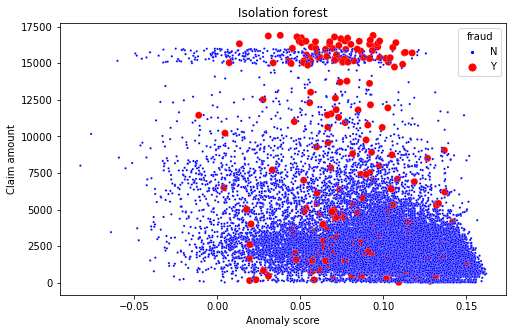

In [244]:
ax = sns.scatterplot(y = 'claim_amount', x = 'anomaly_score', hue = 'fraud',
                 data = data_temp, palette = ['blue', 'red'], 
                     size = 'fraud', sizes = (50, 5))
ax.set_xlabel('Anomaly score')
ax.set_ylabel('Claim amount')
ax.set_title('Isolation forest')
fig = ax.get_figure()
fig.set_size_inches(8, 5)
fig.savefig('isolation_forest_results.png', bbox_inches = 'tight', dpi = 300)

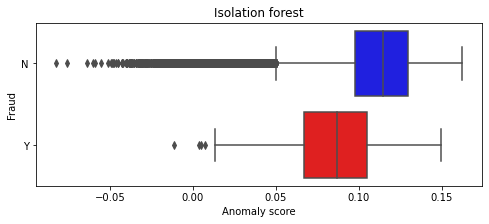

In [254]:
ax = sns.boxplot(x = 'anomaly_score', y = 'fraud',
                 data = data_temp, palette = ['blue', 'red'])
ax.set_xlabel('Anomaly score')
ax.set_ylabel('Fraud')
ax.set_title('Isolation forest')
fig = ax.get_figure()
fig.set_size_inches(8, 3)
fig.savefig('isolation_forest_results2.png', bbox_inches = 'tight', dpi = 300)